do we have gpu access? False 
 what is torch version? 1.6.0 
 how many gpus? 0
image size:  (64, 64, 3)


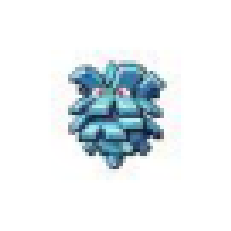

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets
from torchvision.utils import make_grid

# the number of images to process in one go
batch_size = 64
# the path where our images are
# mgan_dataset
image_path = os.path.join('mgan_dataset')
# check that we have access to a GPU, pytorch version, and the number of gpus
print('do we have gpu access? {} \n what is torch version? {} \n how many gpus? {}'.format(torch.cuda.is_available(), 
                                                                                           torch.__version__, 
                                                                                           torch.cuda.device_count()))

# this loads the monster data
# scales it to be 64x64, converts
# it to a torch tensor and then
# normalizes the input to be between
# -1 and 1, also shuffle the dataset
monster_transform = transforms.Compose([
         transforms.Scale(64),
         transforms.CenterCrop(64),
         transforms.ToTensor(), 
         transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
        ])
# this loads the actual files and applies the above transformation
# mgan_dataset megaman
monster_dataset = ImageFolder(image_path, monster_transform)
# thes describes how to load that data, whether to shuffle,
# how mnay cpus (workers to use), ett. it gets batches of 
# data so for example grabbing 64 images at once
monster_loader = data.DataLoader(dataset=monster_dataset, 
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=1)

# check the shape of our pach of images,
# this seems right, we have 64 images and
# they are sized 64x64x3 
for img in monster_loader:
    # renomalize a single image
    single_image = img[0][0]
    single_image= (single_image*0.5)+0.5
    single_image = single_image.clamp(0,1)
    single_image = single_image.numpy()
    # move the dimensions around to get them right
    single_image = np.transpose(single_image, (1, 2, 0))
    # plot image
    print('image size: ',single_image.shape)
    plt.imshow(single_image)
    plt.axis('off')
    plt.show()
    break

In [28]:
# parameters for various parts of the model
n_epochs = 25
lr = 0.0002
label_smooth = 0.9
pokemon_models = os.path.join('mgan_dataset', 'pokemon_models')
noise_dim = 100
d_filter_depth_in = 3

# create our generator network
# this network will take in mgan_dataset
# random noise and output a
# monster.
class Generator(nn.Module):
    # define the model it has 5 transpose
    # convolutions and uses relu activations
    # it has a TanH activation on the last
    # layer
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 
                              512, 
                              kernel_size=4, 
                              stride=1, 
                              padding=0,
                              bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 
                              256, 
                              kernel_size=4, 
                              stride=2,
                              padding=1,
                              bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 
                              128, 
                              kernel_size=4, 
                              stride=2, 
                              padding=1,
                              bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 
                              64, 
                              kernel_size=4, 
                              stride=2, 
                              padding=1,
                              bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 
                               d_filter_depth_in,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
        
    # define how to propagate 
    # through this network
    def forward(self, inputs):
        output = self.main(inputs)
        return output

# create the model that will evaluate 
# the generated monsters
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=d_filter_depth_in, 
                      out_channels=64, 
                      kernel_size=4, 
                      stride=2,
                      padding=1,
                      bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=64, 
                      out_channels=128, 
                      kernel_size=3, 
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=128, 
                      out_channels=256, 
                      kernel_size=4, 
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            
            nn.Conv2d(in_channels=256, 
                      out_channels=512, 
                      kernel_size=4, 
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=512, 
                      out_channels=1, 
                      kernel_size=4, 
                      stride=1,
                      padding=0,
                      bias=False),
            nn.Sigmoid()
        )
        
    # define forward porpagation
    # through that model
    def forward(self, inputs):
        output = self.main(inputs)
        return output.view(-1, 1).squeeze(1)
      
# utility functions

# this iniitilaizes the parameters
# to good rnadom values, you can
# do more research on your own
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        m.weight.data.normal_(1.0,0.02)
        m.bias.data.fill_(0)
        
# this converts any pytorch tensor,
# an n-dimensional array, to a 
# variable and puts it on a gpu if
# a one is available
def to_variable(x):
    '''
    convert a tensor to a variable
    with gradient tracking
    '''
    if torch.cuda.is_available():
        x = x .cuda()
    return Variable(x)

# we're going normalize our images
# to make training the generator easier
# this de-normalizes the images coming out
# of the generator so they look intelligble
def denorm_monsters(x):
    renorm = (x*0.5)+0.5
    return renorm.clamp(0,1)

# this plots a bunch of pokemon
# at the end of each trainign round so
# we can get a sense for how our network
# is doing.
def plot_figure(fixed_noise):
    plt.figure()
    fixed_imgs = generator(fixed_noise)
    result = denorm_monsters(fixed_imgs.cpu().data)
    result = make_grid(result)
    result = transforms.Compose([transforms.ToPILImage()])(result)
    plt.imshow(result)
    plt.axis('off')
    plt.show()
  
# create a generator and
# initialize its weights
generator = Generator()
generator = generator.apply(weights_init)

# create a discriminator and
# initialize its weights
discriminator = Discriminator()
discriminator = discriminator.apply(weights_init)

# create a loss object and optimizers
loss_func = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.99))
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.99))

# it a gpu is available, move all
# the models and the loss function
# to the gpu (more performant)
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    loss_func.cuda()
    
# create a fixed_noise variable so we can evaluate results
# consistently. if we don't do this we'll get different monsters
# everytime we re-run and it will be hard to eavluate our generator
fixed_noise = to_variable(torch.randn(batch_size, noise_dim, 1, 1))


epoch 0
generator loss: 2.42, discriminator loss real: 0.67, discriminator loss fake: 0.38


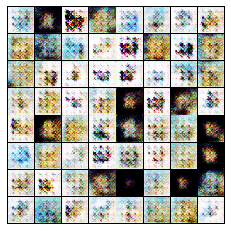

epoch 1
generator loss: 2.67, discriminator loss real: 0.61, discriminator loss fake: 0.32


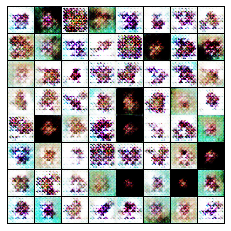

epoch 2
generator loss: 2.47, discriminator loss real: 0.67, discriminator loss fake: 0.37


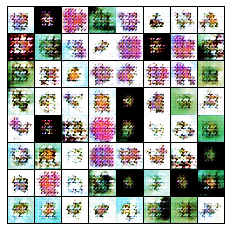

epoch 3
generator loss: 2.59, discriminator loss real: 0.63, discriminator loss fake: 0.35


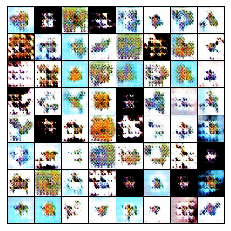

epoch 4
generator loss: 2.54, discriminator loss real: 0.63, discriminator loss fake: 0.36


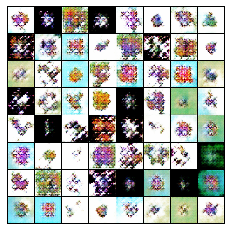

epoch 5
generator loss: 2.60, discriminator loss real: 0.62, discriminator loss fake: 0.33


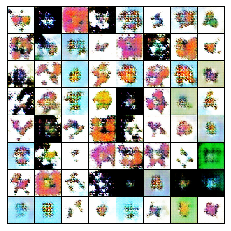

KeyboardInterrupt: 

In [30]:
# keep track of losses
# from the generator and
# discriminator
generator_losses = []
discriminator_losses = []

# for some number of rounds (epochs)
for epoch in range(n_epochs):
    # track losses for this epoch
    gen_loss_epoch = 0
    dis_loss_epoch_fake = 0
    dis_loss_epoch_real = 0
    batches_processed = 0
    # for every batch of images
    for i, image_batch in enumerate(monster_loader):
        # track the number of batches processed
        batches_processed += 1
        # get the batch size of the
        # current batch ()
        image_batch = image_batch[0]
        batch_size = image_batch.shape[0]
        
        # --- train discriminator ---
        # clear gradients
        discriminator.zero_grad()
        
        # train discriminator on real images
        real_images = to_variable(image_batch)
        real_outputs = discriminator(real_images)
        real_loss = loss_func(real_outputs, to_variable(torch.ones(real_outputs.data.shape))*label_smooth)
        real_loss.backward()
        dis_loss_epoch_real += torch.mean(real_loss.data)
        
        # train dsicriminator on generated images
        noise = to_variable(torch.randn(batch_size, noise_dim, 1, 1))
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images)
        fake_loss = loss_func(fake_outputs, to_variable(torch.zeros(fake_outputs.data.shape)))
        fake_loss.backward()
        dis_loss_epoch_fake += torch.mean(fake_loss.data)
        
        # update discriminator params
        d_optimizer.step()
        
        # --- train generator ---
        generator.zero_grad()
        
        # generate noise and feed it to the generator
        # to make an image
        noise = to_variable(torch.randn(batch_size, noise_dim, 1, 1))
        fake_images = generator(noise)
        dis_outputs = discriminator(fake_images)
        gen_loss = loss_func(dis_outputs, to_variable(torch.ones(dis_outputs.data.shape)))
        gen_loss.backward()
        gen_loss_epoch += torch.mean(gen_loss.data)
        
        # update generator params
        g_optimizer.step()
        
    discriminator_losses.append([dis_loss_epoch_real/batches_processed, dis_loss_epoch_fake/batches_processed])
    generator_losses.append(gen_loss_epoch/batches_processed)
        
    print('epoch {}'.format(epoch))
    print('generator loss: {:0.2f}, discriminator loss real: {:0.2f}, discriminator loss fake: {:0.2f}'.format(generator_losses[-1], discriminator_losses[-1][0], discriminator_losses[-1][1]))   
    
    plot_figure(fixed_noise)
    
    # save this epoch's model.
    torch.save(generator.state_dict(), os.path.join(pokemon_models, 'generator_ep_%d' % epoch))
    torch.save(discriminator.state_dict(), os.path.join(pokemon_models, 'discriminator_ep_%d' % epoch))

In [34]:
# create new noise to pass to the generator
noise = to_variable(torch.randn(batch_size, noise_dim, 1, 1))

# load the generator from epoch 90 of training
load_model = os.path.join(pokemon_models, 'generator_ep_%d' % 4)
generator_final = Generator()
generator_final.load_state_dict(torch.load(load_model))
generator_final.cuda()

# generate new monsters
fixed_imgs = generator_final(noise)
result = denorm_monsters(fixed_imgs.cpu().data)
result = make_grid(result)
result = transforms.Compose([transforms.ToPILImage()])(result)

# plot those monsters
plt.figure(figsize=(20,15))
plt.imshow(result)
plt.axis('off')
_ = plt.show() 

AssertionError: Torch not compiled with CUDA enabled